# 3rd Nanjing GRB conference

# Installation of the code
requirements: Python, numpy, and a c++ compiler.<br>
download the code: <br> 
```
git clone https://github.com/haowang-astro/jetsimpy
```
install from source: <br>
```
cd jetsimpy
pip install . && python setup.py clean

```
The second "clean" command is necessary. 

Let's first define a dictionary of parameters to be used later.

In [2]:
import jetsimpy
import numpy as np
from matplotlib import pyplot as plt

P = dict(
    Eiso = 1e52,        # Isotropic equivalent energy
    lf = 300,           # Lorentz factor
    theta_c = 0.1,      # half opening angle
    n0 = 1,             # ism number density
    A = 0,              # wind number density amplitude
    eps_e = 0.1,        # epsilon_e
    eps_b = 0.01,       # epsilon_b
    p = 2.17,           # electron power index
    theta_v = 0.4,      # viewing angle (rad)
    d = 474.33,         # distance (Mpc)
    z = 0.1,            # redshift
)

## Step 1. define the jet structure.
There are some built-in jet structures in the code:<br>
A top-hat jet: `jetsimpy.TopHat(P["theta_c"], P["Eiso"], lf0=P["lf"])`<br>
A Gaussian jet: `jetsimpy.Gaussian(P["theta_c"], P["Eiso"], lf0=P["lf"])`<br>
A Power-law jet `jetsimpy.PowerLaw(P["theta_c"], P["Eiso"], lf0=P["lf"], s=4.0)`<br>
For now, let's choose the Gaussian jet.

In [3]:
theta, Eiso, lf = jetsimpy.Gaussian(P["theta_c"], P["Eiso"], lf0=P["lf"])

## Step 2. solve the hydrodynmaics of a jet

In [4]:
jet = jetsimpy.Jet(
    (theta, Eiso, lf),             # [tuple of tabulated data]: (polar angles, rest mass excluded energy, Lorentz factor)
    P["A"],                        # [wind density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
    P["n0"],                       # [ism density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
    tmin=10.0,                     # [simulation start time]: (s)
    tmax=3.2e9,                    # [simulation end time]: (s)
    grid=jetsimpy.NorthPole(P["theta_c"], 129),    # [cell edge angles]: must start with 0 and end with pi.
    tail=True,                     # [isotropic tail]: add an extremely low energy low velocity isotropic tail for safty
    spread=True,                   # w/wo spreading effect 
    cal_level=1,                   # [calibration level]: 0: no calibration. 1: BM all time. 2: smoothly go from BM to ST (dangerous)
    rtol=1e-6,                     # [primitive variable solver tolerance]: Don't change it unless you know what is going on.
    cfl=0.9,                       # [cfl number]: Don't change it unless you know what is going on.
)

### Some notes on the keyword arguments
1. `theta` must go from 0 to pi.
2. `Eiso` must be strictly possitive.
3. `lf` must be strictly larger than 1.
4. `tmin` is the start time. The jet will initially coast from t=0 to this time.
5. `grid` is an 1D `np.array` of cell "edge" positions. It must start form 0 and end with pi.
6. `tail` is an option to add an isotropic tail with low energy and low speed. The purpose of is parameter is to make sure Eiso>0 and lf>1, which is important for the code to work properly. If you are 100% confident of your initial jet profile, you can turn off this option.
7. `cal_level` is the level of calibration. 0: no calibration. 1: Blandford-McKee. 2: smoothly go from Blandford-McKee to Sedov-Taylor. The default option is `cal_level=1`. Note that `cal_level=2` may be dangerous, because in Newtonian limit the shell is not thin, and the calibration may not make sense.
8. `rtol` and `cfl` are the parameters you should not change.

## Step 2. Calculate the afterglow observables
### Flux density

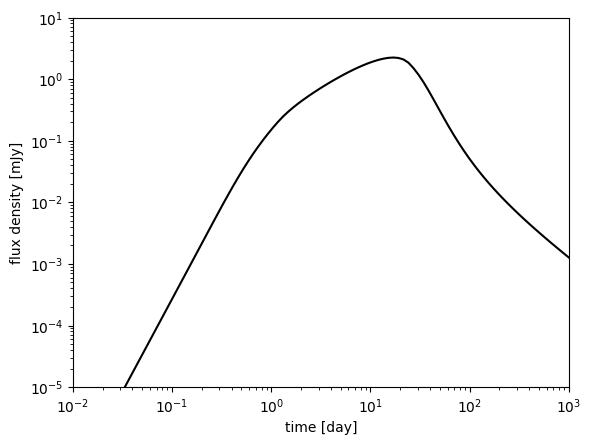

In [5]:
# define the observing time and frequency
tday = np.logspace(-2, 3, 100)
tsecond = tday * 3600 * 24
nu = 3e9

# calculate the afterglow flux density (unit: mJy)
flux = jet.FluxDensity(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary
    model="sync",      # emissivity model
    rtol=1e-3,         # integration tolerance
)

# plot the light curves
plt.plot(tday, flux, color="black")
plt.xlim(1e-2, 1e3)
plt.ylim(1e-5, 1e1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("time [day]")
plt.ylabel("flux density [mJy]")
plt.show()

### Some notes on the keyword arguments
1. The parameter distionary `P` must be compatible with radiation model `model`. Namely, the parameters used in the `model` (defined in a C++ source file) must be specified in `P`. Moreover, three parameters must be specified no matter what model you are using: `theta_v` the observing angle, `d` the luminosity distance, and `z` the redshift.
2. `model` is a string referring to a radiation model defined in a C++ file to be explained later. The default model is `model='sync'` which is the standard synchrotron radiation model without self-absorption. The necessary parameters to be used in `model='sync'` are `eps_e`, `eps_b`, and `p`.
3. `rtol` is the integral tolerance. Default value is `rtol=1e-3`.

### Apparent superluminal motion

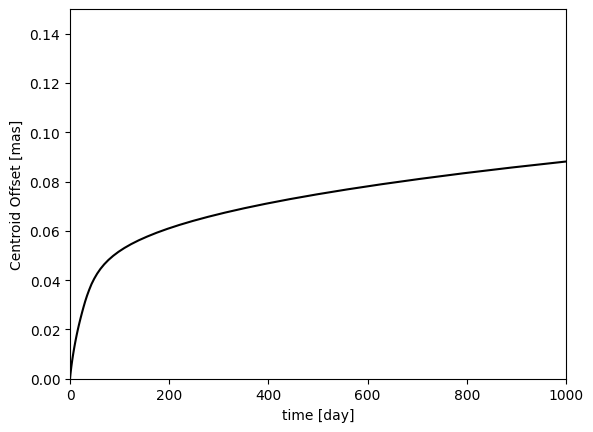

In [6]:
offset = jet.Offset(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

plt.plot(tday, offset, color="black")
plt.xlim(0, 1e3)
plt.ylim(0, 0.15)
plt.xlabel("time [day]")
plt.ylabel("Centroid Offset [mas]")
plt.show()

### image size

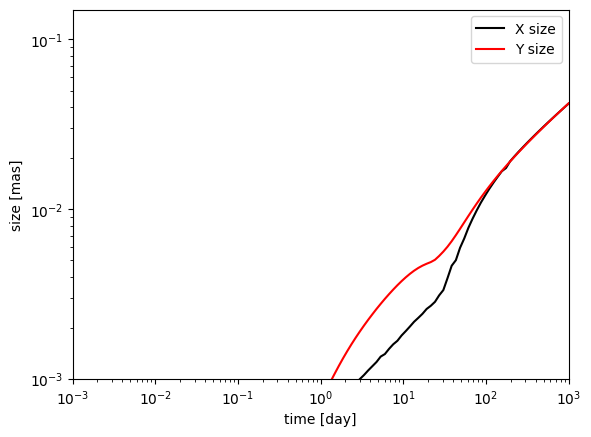

In [8]:
# X direction is along the jet axis.
x_size = jet.SizeX(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

# Y direction is perpendicular to the jet axis
y_size = jet.SizeY(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

plt.plot(tday, x_size, color="black", label="X size")
plt.plot(tday, y_size, color="red", label="Y size")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-3, 0.15)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("time [day]")
plt.ylabel("size [mas]")
plt.legend()
plt.show()

### sky map

In [9]:
# time and frequency of sky map
tday = 10
nu = 3e9
tsecond = tday * 3600 * 24

# make an image with half width: (centroid + 3 * size_x) [unit: mas],
# such that the whole jet is visible in the image
offset = jet.Offset(tsecond, nu, P)
size_x = jet.SizeX(tsecond, nu, P)
size_y = jet.SizeY(tsecond, nu, P)
half_width = offset + 3 * size_x

# intensity map data matrix: resolution 300 x 300
resolution = 300
x_tilde = np.linspace(- half_width, half_width, resolution)    # x pixel coordinates
y_tilde = np.linspace(- half_width, half_width, resolution)    # y pixel coordinates
X, Y = np.meshgrid(x_tilde, y_tilde)
sky_map = jet.IntensityOfPixel(tsecond, nu, X, Y, P)

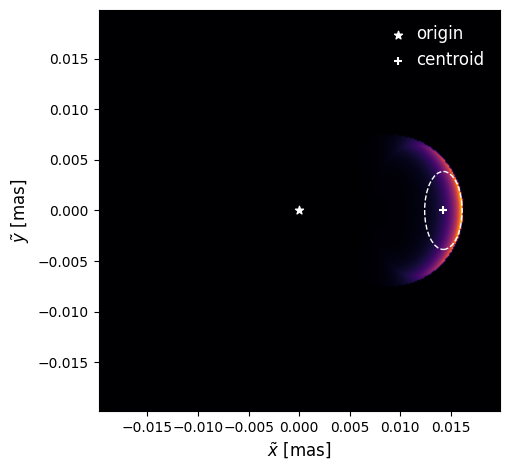

In [10]:
from matplotlib.patches import Ellipse
# configurate the plot
fig, ax = plt.subplots()
Inorm = sky_map / sky_map.max()    # normalize to 1
Inorm = np.rot90(Inorm, 2)         # rotate to align the plt.imshow() extent
im = ax.imshow(Inorm, interpolation='gaussian', cmap="inferno", extent=[-half_width, half_width, -half_width, half_width])
im.set_clim(vmin=0.0, vmax=1.0)

# plot the origin, centroid, and [optional] size contour just for fun! (you are welcome to uncomment the line below.)
ax.scatter(0, 0, marker="*", color="white", label="origin")
ax.scatter(offset, 0.0, marker="+", color="white", label="centroid")
ax.add_patch(Ellipse((offset, 0), size_x * 2, size_y * 2, edgecolor="white", fill=False, linestyle="--", linewidth=1))

# show the image!
ax.set_xlabel(r"$\tilde{x}$ [mas]", fontsize=12)
ax.set_ylabel(r"$\tilde{y}$ [mas]", fontsize=12)
ax.legend(loc="upper right", frameon=False, labelcolor="white", fontsize=12, handletextpad=0.1)
fig.tight_layout()
plt.show()

## Access the hydrodynamic results
1. `jet.dE0_dOmega(t, theta)`. Rest mass excluded angular energy profile.
2. `jet.dMsw_dOmega(t, theta)`. Swept-up mass angular profile.
3. `jet.dMej_dOmega(t, theta)`. ejecta mass angular profile.
4. `jet.beta_gamma(t, theta)`. 4-velocity angular profile.
5. `jet.beta_theta(t, theta)`. tangent velocity angular profile.
6. `jet.R(t, theta)`. Radius angular profile.

In [11]:
# generate data
t = 100 * 3600 * 24
theta = np.linspace(0, np.pi, 1000)
dE_dOmega = jet.dE0_dOmega(t, theta)
beta_gamma = jet.beta_gamma(t, theta)

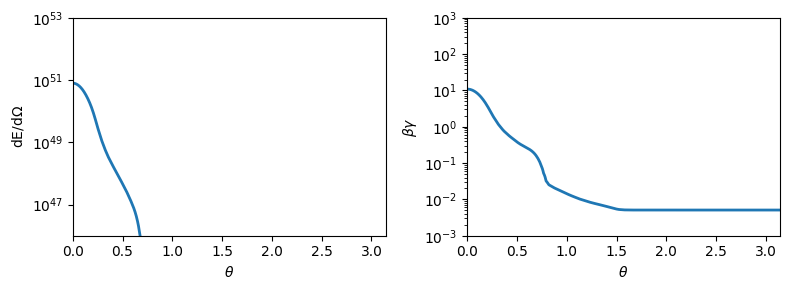

In [12]:
from matplotlib import animation

# configure the canvas
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(theta, dE_dOmega, lw=2)
axes[0].set_yscale("log")
axes[0].set_ylim(1e46, 1e53)
axes[0].set_xlim(0, np.pi)
axes[0].set_xlabel(r"$\theta$")
axes[0].set_ylabel(r"dE/d$\Omega$")

axes[1].plot(theta, beta_gamma, lw=2)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-3, 1e3)
axes[1].set_xlim(0, np.pi)
axes[1].set_xlabel(r"$\theta$")
axes[1].set_ylabel(r"$\beta\gamma$")
fig.tight_layout()

# Advanced topics
## Define your own emissivity model
To customize the emissivity model ($\epsilon'_{\nu'}$), you have to work on the source file. 
#### what if I don't master C++?
Don't worry! You only need 0.1% knowlege of C++ to work on this part.
#### what if I don't understand the code structure?
Don't worry! The emissivity function is highly modulized and is isolated from other parts of the code. You can define $\epsilon'_{\nu'}$ without knowing any other parts of the code.

### what should I do?
The emissivity models are defined in the source file "jetsimpy/src/Afterglow/models.cpp". In this file, there is a function `Models::registerEmissivity()`, which is the space for you to add your own emissivity model. <br>
In the scope of this function, you can add your emissivity model by defining a C++ lambda function.
```
emissivity_models["model_name"] = [](const double nu, const Dict& P, const Blast& blast) {
    // define your emissivity here
    return emissivity;
};
```
By means of emissivity, you actually define the frequency dependent power of an infinitely small fluid element.
### what are the parameters?
`nu` is the frequency.<br>
`P` is the parameter dictionary you defined from Python side.<br>
`blast` is an object (a struct in C++) for you to access all necessary properties of a fluid elements.
### `blast` properties explained
`blast.t`: time (burster frame)<br>
`blast.theta`: polar angle (burster frame)<br>
`blast.phi`: azimuthal angle (burster frame)<br>
`blast.R`: radius (burster frame)<br>
`blast.beta`: post-shock velocity (burster frame)<br>
`blast.gamma`: post-shock Lorentz factor (burster frame)<br>
`blast.beta_th`: polar velocity component of `beta` (burster frame)<br>
`blast.beta_r`: radial velocity component of `beta` (burster frame)<br>
`blast.beta_f`: velocity of the forward shock (burster frame). Note this is different from `beta`<br>
`blast.gamma_f`: Lorentz factor of the forward shock (burster frame)<br>
`blast.s`: calibration coefficient<br>
`blast.doppler`: doppler factor (burster frame)<br>
`blast.n_blast`: post-shock number density (comoving frame)<br>
`blast.e_density`: post-shock energy density (comoving frame)<br>
`blast.pressure`: post-shock pressure (comoving frame)<br>
`blast.n_ambient`: external medium density (burster frame)<br>
`blast.dR`: shell width  (comoving frame)<br>

## example: the default emissivity model
```
emissivity_models["sync"] = [](const double nu, const Dict& P, const Blast& blast) {
        double eps_e = P.at("eps_e");
        double eps_b = P.at("eps_b");
        double p = P.at("p");
        
        double n_blast = blast.n_blast;
        double t = blast.t;
        double gamma = blast.gamma;
        double e = blast.e_density;
    
        double emissivity;
        double gamma_m, gamma_c, B, nu_m, nu_c, e_p;
        
        gamma_m = (p - 2.0) / (p - 1.0) * (eps_e * MassP / MassE * (gamma - 1.0));
        B = std::sqrt(8.0 * PI * eps_b * e);
        gamma_c = 6.0 * PI * MassE * gamma * CSpeed / SigmaT / B / B / t;
        nu_m = 3.0 * ECharge * B * gamma_m * gamma_m / 4.0 / PI / CSpeed / MassE;
        nu_c = 3.0 * ECharge * B * gamma_c * gamma_c / 4.0 / PI / CSpeed / MassE;
        e_p = std::sqrt(3.0) * ECharge * ECharge * ECharge * B * n_blast / MassE / CSpeed / CSpeed;

        if (nu_m < nu_c) {
            if (nu < nu_m) {
                emissivity = e_p * std::cbrt(nu / nu_m);
            }
            else if (nu < nu_c) {
                emissivity = e_p * std::pow(nu / nu_m, - (p - 1) / 2.0);
            }
            else {
                emissivity = e_p * std::pow(nu_c / nu_m, - (p - 1) / 2.0) * std::pow(nu / nu_c, - p / 2);
            }
        }
        else {
            if (nu < nu_c) {
                emissivity = e_p * std::cbrt(nu / nu_c);
            }
            else if (nu < nu_m) {
                emissivity = e_p / std::sqrt(nu / nu_c);
            }
            else {
                emissivity = e_p / std::sqrt(nu_m / nu_c) * std::pow(nu / nu_m, - p / 2);
            }
        }

        return emissivity;
    };
```
remember to install the code again to make sure the above implimentation is enabled.
#### global variables
There have already been some global constants defined in the code. See "jetsimpy/src/environment.h" for details.

## A bonus topic: define your "weighted average" model
Because GRBs are at cosmological distances, we can't spatially resolve the blastwave. Therefore, all measurable values are kind of "weighted average" over the fluid elements along the blastwave, where the weight is $dL_{\nu}/d\Omega$. For example, the "centroid" is the weighted average of the coordinate position of all fluid elements:<br>
$\tilde{x}_{\rm c} = \frac{\int R\lambda_{\rm r} \frac{dL_{\nu}}{d\Omega}d\Omega}{\int \frac{dL_{\nu}}{d\Omega}d\Omega}$, <br>
where $\lambda_{\rm r} = - \sin\theta\cos\phi\cos\theta_{\rm v} + \cos\theta\sin\theta_{\rm v}$.<br>
We provide an interface in the code for users to define their own models of weighted average.

Below is the example of how the default "centroid" is calculated in the code.

Similar to emissivity models, we still enter the source file "jetsimpy/src/Afterglow/models.cpp". There is function called `Models::registerAvgModels()`, where in the scope of this function you define the quantity you would like to average. For the centroid, what we would like to average is the position of fluid elements projected to the "line of sight plane":<br>
$R\lambda_{\rm r}$.<br>
So we need to define a C++ lambda function to calculate this value, and label it with a string:
```
avg_models["offset"] = [](const double nu, const Dict& P, const Blast& blast) {
    double theta_v = P.at("theta_v");
    double lambda_r = - std::sin(blast.theta) * std::cos(blast.phi) * std::cos(theta_v) + std::cos(blast.theta) * std::sin(theta_v);
    return lambda_r * blast.R;
};
```
remember to install the code again to make sure the above implimentation is enabled.

To calculate the weighted average, run the following function from python side
```
jet.WeightedAverage(t, nu, P, emissitivy_model="sync", average_model="offset")
```
The `emissivity_model` tells the program how to calculate $dL/d\Omega$ (the weight), and the `average_model` tells the program what to average.

This API is useful in many cases. For example, the polarization of GRB afterglow is also a weighted average. You can try to calculate the polarization based on [Gill & Granot 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.478.4128G/abstract) eq. 26.